In [7]:
import nibabel
import neurosynth
import os

import pandas as pd
import neurolang.regions as nlr

from nilearn import plotting
import numpy as np

from neurolang.expressions import Symbol, Constant, ExpressionBlock
from neurolang.datalog.expressions import Implication, Fact, Conjunction
from neurolang.probabilistic.expressions import ProbabilisticPredicate
from neurolang.probabilistic.probdatalog import ProbDatalogProgram


/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/Users/gzanitti/Projects/INRIA/NeuroLang/neurolang/solver_datalog_naive.py:24: UserWarning: This module is being deprecated please use the datalog module
  warn("This module is being deprecated please use the datalog module")
/Users/gzanitti/Projects/INRIA/NeuroLang/neurolang/expression_pattern_matching.py:87: UserWarning: Warning in class SolverNonRecursiveDatalogNaive overwrites ['fact', 'statement_intensional'] from base DatalogProgram[typing.Any]
  warn(warn_message)


In [8]:
#term_prob.to_hdf('neurosynth_prob.h5', key='terms')
#activation_prob.to_hdf('neurosynth_prob.h5', key='voxels')
#term_voxel.to_hdf('neurosynth_prob.h5', key='terms_voxels')

prob_terms = pd.read_hdf('neurosynth_prob.h5', key='terms')
prob_voxels = pd.read_hdf('neurosynth_prob.h5', key='voxels')
prob_terms_voxels = pd.read_hdf('neurosynth_prob.h5', key='terms_voxels')

/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [21]:
prob_terms[prob_terms['index'] == 'auditory']

,index,proba
272,auditory,0.08712


In [ ]:
pred_facts_voxels = []
pred_facts_terms = []
pred_facts_terms_voxels = []

voxel_sym = Symbol('Voxel')
term_sym = Symbol('Term')
voxel_term_symb = Symbol('VoxelTerm')

prob_terms.head()
for index, row in prob_terms.iterrows():
    prob = Constant(row['proba'])
    t_name = Constant(row['index'])
    pred = Implication(ProbabilisticPredicate(prob, term_sym(t_name)),Constant[bool](True))
    pred_facts_terms.append(pred)
    
for index, row in prob_voxels.iterrows():
    prob = Constant(row[0])
    v_name = Constant(index)
    pred = Implication(ProbabilisticPredicate(prob, voxel_sym(v_name)),Constant[bool](True))
    pred_facts_voxels.append(pred)
    
for index, row in prob_terms_voxels.iterrows():
    t_name = Constant(index[0])
    v_name = Constant(index[1])
    prob = Constant(row['prob'])
    pred = Implication(ProbabilisticPredicate(prob, voxel_term_symb(t_name, v_name)),Constant[bool](True))
    pred_facts_terms_voxels.append(pred)

In [12]:
def get_xyz_from_neurosynth():
    
    ns_base_img = nibabel.load(
    os.path.join(
        neurosynth.__path__[0], "resources/MNI152_T1_2mm_brain.nii.gz",
        )
    )

    ns_masker = neurosynth.mask.Masker(
        os.path.join(
            neurosynth.__path__[0], "resources/MNI152_T1_2mm_brain.nii.gz",
        )
    )

    ns_affine = ns_base_img.affine

    voxels = np.ones(shape=ns_masker.mask(ns_base_img.get_data()).shape)
    unmasked = ns_masker.unmask(voxels)
    ijk = np.argwhere(unmasked > 0)
    ret = {}
    regions = [
        nlr.ExplicitVBR(
            [coords],
            affine_matrix=ns_affine,
            image_dim=ns_base_img.get_data().shape,
        )
        for coords in ijk
    ]
    for vid, region in zip(range(voxels.shape[0]), regions):
        ret[vid] = region
        
    return ret

ret = get_xyz_from_neurosynth()

/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.7/site-packages/neurosynth/base/mask.py:232: DeprecationWarning: get_header method is deprecated.
Please use the ``img.header`` property instead.

* deprecated from version: 2.1
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 4.0
  return self.volume.get_header()


In [4]:
prob_terms.head()

,index,proba
0,001,0.010229
1,01,0.009811
2,05,0.022685
3,10,0.057268
4,100,0.010020


In [5]:
prob_voxels.head()

,0
0,0.005010
1,0.004871
2,0.004523
3,0.004941
4,0.004801


In [6]:
prob_terms_voxels.head()

index      prob
term variable                 
01   1301          3  0.000209
     2195          4  0.000278
     2196          3  0.000209
     2197          4  0.000278
     2233          2  0.000139

In [9]:
auditory = prob_terms_voxels[prob_terms_voxels.index.get_level_values('term') == 'auditory']

In [10]:
auditory.head()

index      prob
term     variable                 
auditory 0            11  0.000765
         1            13  0.000905
         2            13  0.000905
         9             7  0.000487
         11           10  0.000696

In [13]:
regions = []
for index, row in auditory.iterrows():
    prob = row['prob']
    v_name = index[1]
    region = ret[v_name]
    regions.append((region, prob))

In [14]:
regions[0][0].image_dim

(91, 109, 91)

In [15]:
prob_img = nibabel.spatialimages.SpatialImage(
    np.zeros(regions[0][0].image_dim, dtype=float),
    affine=regions[0][0].affine
)

for r, p in regions:
    prob_img.dataobj[tuple(r.voxels.T)] = p

In [16]:
r.voxels.T

array([[76],
       [53],
       [21]])

In [17]:
regions[0][0].image_dim

(91, 109, 91)

/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.7/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.7/site-packages/nilearn/plotting/displays.py:600: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if isinstance(axes, collections.Sequence):


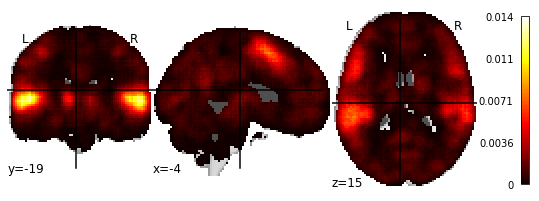

In [18]:
plotting.plot_stat_map(prob_img, title='')